In [1]:
# training a model with pre-defined (and saved) train / test datasets

In [2]:
# reading the data ml-latest-small
import pandas as pd
import zipfile
import numpy as np 
zf = zipfile.ZipFile('/home/elena/Downloads/ml-latest-small.zip')
# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(zf.open('ml-latest-small/ratings.csv'), names=r_cols)
m_cols=['movie_id', 'title', 'genre']
movies = pd.read_csv(zf.open('ml-latest-small/movies.csv'), names=m_cols)
# merging ratings and movies
data=pd.merge(ratings,movies,on='movie_id')
data.head()

,user_id,movie_id,rating,unix_timestamp,title,genre
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [3]:
zz = zipfile.ZipFile('/home/elena/Downloads/ml-100k.zip')
# reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(zz.open('ml-100k/u.user'), sep='|', names=u_cols,encoding='latin-1')
data=pd.merge(users,data, on='user_id')
data.head()

,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre
0,1,24,M,technician,85711,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,24,M,technician,85711,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,24,M,technician,85711,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,24,M,technician,85711,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,24,M,technician,85711,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [4]:
data.movie_id.unique().shape[0], data.user_id.unique().shape[0], data.shape

(9724, 610, (100836, 10))

In [5]:
# splitting into train and test data
# data was split and safed! 
train=pd.read_pickle('/home/elena/Downloads/traindata.pkl')
test=pd.read_pickle('/home/elena/Downloads/testdata.pkl')

In [6]:
train.head()

,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre
97717,606,28,M,programmer,63044,3462,4.0,1171501099,Modern Times (1936),Comedy|Drama|Romance
100124,610,22,M,student,21227,8914,4.0,1493845360,Primer (2004),Drama|Sci-Fi
25952,180,22,F,administrator,60202,1196,4.0,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
25871,178,26,M,other,49512,2231,4.5,1163673637,Rounders (1998),Drama
97255,605,33,M,engineer,33716,1588,4.0,1277094877,George of the Jungle (1997),Children|Comedy


In [7]:
data.movie_id.max(), data.user_id.max(), train.movie_id.max(), train.user_id.max()

(193609, 610, 193609, 610)

In [8]:
# Implementation 
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dot, Add, Multiply, Subtract, Average
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [12]:
def embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value,merging_method):
    # Each instance will consist of two inputs: a single user id, and a single movie id
    user_id_input = Input(shape=(1,), name='user_id')
    movie_id_input = Input(shape=(1,), name='movie_id')
    # Embeddings
    user_embedded = Embedding(user_max_cat_value+1, user_embedding_dim, 
                                       input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = Embedding(movie_max_cat_value+1, movie_embedding_dim, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
    # merging the embeddings
    if merging_method=='concatenate':
        merged = Concatenate()([user_embedded, movie_embedded])
    if merging_method=='dot_product':
        merged =Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedded, movie_embedded])
    if merging_method=='add':
        merged =Add()([user_embedded, movie_embedded])
    if merging_method=='substract':
        merged=Subtract()([user_embedded, movie_embedded])
    if merging_method=='multiply':
        merged=Multiply()([user_embedded, movie_embedded])
    if merging_method=='average':
        merged=Average()([user_embedded, movie_embedded])
    out = Flatten()(merged)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = Dense(1, activation='linear', name='prediction')(out)
    model=Model(inputs = [user_id_input, movie_id_input],outputs = out)
    model.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
    return model

In [13]:
hidden_units = (100,50) #same as in pytorch model
movie_embedding_dim = 50 #same as in pytorch model
user_embedding_dim = 50  #same as in pytorch model
user_max_cat_value = data.user_id.max()
movie_max_cat_value=data.movie_id.max()
# early stopping
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)

In [14]:
model_concatenate=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='concatenate')
model_concatenate.summary(line_length=88)

Model: "model_2"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         (None, 1)          0                                       
________________________________________________________________________________________
movie_id (InputLayer)        (None, 1)          0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 50)      30550     user_id[0][0]                 
________________________________________________________________________________________
movie_embedding (Embedding)  (None, 1, 50)      9680500   movie_id[0][0]                
________________________________________________________________________________________
concatenate_2 (Concatenate)  (None, 1, 100)     0         user_embedding[0][0]          
    

In [15]:
trained_model_concatenate= model_concatenate.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 45s - loss: 3.1264 - MAE: 1.2937 - val_loss: 0.7854 - val_MAE: 0.6850
Epoch 2/10
 - 44s - loss: 0.7315 - MAE: 0.6583 - val_loss: 0.7666 - val_MAE: 0.6736
Epoch 3/10
 - 49s - loss: 0.6948 - MAE: 0.6388 - val_loss: 0.7693 - val_MAE: 0.6735
Epoch 4/10
 - 48s - loss: 0.6777 - MAE: 0.6295 - val_loss: 0.7709 - val_MAE: 0.6740


In [24]:
epochs_model_concatenate=len(trained_model_concatenate.epoch)
MAE_model_concatenate=0.6295   # old 0.6300
val_MAE_model_concatenate=0.6740 # old 0.6745

In [18]:
# using the evaluate method
trained_model_concatenate2= model_concatenate.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10)

Epoch 1/10
75627/75627 [==============================] - 45s 596us/step - loss: 0.6668 - MAE: 0.6233
Epoch 2/10
75627/75627 [==============================] - 44s 587us/step - loss: 0.6570 - MAE: 0.6172
Epoch 3/10
75627/75627 [==============================] - 44s 588us/step - loss: 0.6443 - MAE: 0.6099
Epoch 4/10
75627/75627 [==============================] - 46s 604us/step - loss: 0.6226 - MAE: 0.5984
Epoch 5/10
75627/75627 [==============================] - 45s 593us/step - loss: 0.5971 - MAE: 0.5844
Epoch 6/10
75627/75627 [==============================] - 47s 621us/step - loss: 0.5674 - MAE: 0.5680
Epoch 7/10
75627/75627 [==============================] - 48s 637us/step - loss: 0.5360 - MAE: 0.5508
Epoch 8/10
75627/75627 [==============================] - 50s 667us/step - loss: 0.5028 - MAE: 0.5324
Epoch 9/10
75627/75627 [==============================] - 54s 709us/step - loss: 0.4693 - MAE: 0.5131
Epoch 10/10
75627/75627 [==============================] - 57s 756us/step - loss: 

In [22]:
model_concatenate.evaluate(x=[test.user_id, test.movie_id], y=test.rating)

25209/25209 [==============================] - 1s 24us/step


[0.8338149585232645, 0.697068452835083]

In [23]:
model_concatenate.metrics_names

['loss', 'MAE']

In [15]:
model_dot=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='dot_product')

In [26]:
# training and using the pre-defined train and test data
trained_model_dot= model_dot.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 53s - loss: 4.7529 - MAE: 1.7255 - val_loss: 1.0836 - val_MAE: 0.8252
Epoch 2/10
 - 57s - loss: 1.0672 - MAE: 0.8238 - val_loss: 1.0869 - val_MAE: 0.8376


In [27]:
epochs_model_dot=len(trained_model_dot.epoch)
MAE_model_dot=0.8238 # old 0.8221
val_MAE_model_dot=0.8376 # old 0.8315

In [16]:
model_add=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='add')

In [33]:
# training and using the pre-defined train and test data
trained_model_add= model_add.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 48s - loss: 2.8870 - MAE: 1.2383 - val_loss: 0.7986 - val_MAE: 0.6903
Epoch 2/10
 - 33s - loss: 0.7317 - MAE: 0.6587 - val_loss: 0.7764 - val_MAE: 0.6785
Epoch 3/10
 - 32s - loss: 0.6899 - MAE: 0.6363 - val_loss: 0.7743 - val_MAE: 0.6801


In [92]:
epochs_model_add=len(trained_model_add.epoch)
MAE_model_add=0.6619
val_MAE_model_add=0.6759

In [17]:
model_substract=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='substract')

In [87]:
# training and using the pre-defined train and test data
trained_model_substract= model_substract.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 46s - loss: 3.2603 - MAE: 1.3247 - val_loss: 0.7964 - val_MAE: 0.6911
Epoch 2/10
 - 47s - loss: 0.7318 - MAE: 0.6589 - val_loss: 0.7733 - val_MAE: 0.6768
Epoch 3/10
 - 48s - loss: 0.6909 - MAE: 0.6370 - val_loss: 0.7731 - val_MAE: 0.6766
Epoch 4/10
 - 48s - loss: 0.6723 - MAE: 0.6259 - val_loss: 0.7727 - val_MAE: 0.6739
Epoch 5/10
 - 48s - loss: 0.6579 - MAE: 0.6178 - val_loss: 0.7727 - val_MAE: 0.6734
Epoch 6/10
 - 47s - loss: 0.6429 - MAE: 0.6100 - val_loss: 0.7707 - val_MAE: 0.6730
Epoch 7/10
 - 46s - loss: 0.6186 - MAE: 0.5960 - val_loss: 0.7775 - val_MAE: 0.6773


In [88]:
epochs_model_substract=len(trained_model_substract.epoch)
MAE_model_substract=0.6186 # old 0.6157
val_MAE_model_substract=0.6773 # old 0.6757

In [18]:
model_multiply=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='multiply')

In [89]:
model_multiply=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='multiply')
# training and using the pre-defined train and test data
history_multiply= model_multiply.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 45s - loss: 4.1118 - MAE: 1.5775 - val_loss: 1.0788 - val_MAE: 0.8229
Epoch 2/10
 - 47s - loss: 0.9389 - MAE: 0.7617 - val_loss: 0.8676 - val_MAE: 0.7251
Epoch 3/10
 - 46s - loss: 0.4674 - MAE: 0.5177 - val_loss: 0.8758 - val_MAE: 0.7270


In [93]:
epochs_model_multiply=len(history_multiply.epoch)
MAE_model_mulitply=0.5177 # old 0.5231
val_MAE_model_multiply=0.7270 # old 0.7370 # overfitting?

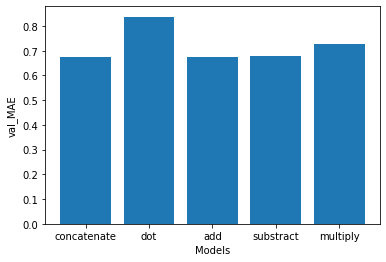

In [94]:
# we can directly acess the mae and val_mae if we safe the model under the name history (command will be 
# history.history['MAE'])
import matplotlib.pyplot as plt
%matplotlib inline
models=('concatenate', 'dot', 'add', 'substract', 'multiply')
mae_values=(MAE_model_concatenate, MAE_model_dot, MAE_model_add, MAE_model_substract, MAE_model_mulitply)
val_mae_values=(val_MAE_model_concatenate, val_MAE_model_dot, val_MAE_model_add, val_MAE_model_substract, val_MAE_model_multiply )
pos=np.arange(len(models))
plt.bar(pos,val_mae_values,align='center')
plt.xticks(pos,models)
plt.ylabel('val_MAE')
plt.xlabel('Models')
plt.show()

In [56]:
# example prediction

In [19]:
# User 
ratings_per_user = data.groupby('user_id').size()
uid = 1
user_ratings = data[data.user_id==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
cols = ['user_id', 'movie_id', 'rating']
user_ratings.sort_values(by='rating', ascending=False)[cols]

User #1 has rated 232 movies (avg. rating = 4.4):


,user_id,movie_id,rating
231,1,5060,5.0
185,1,2872,5.0
89,1,1291,5.0
90,1,1298,5.0
190,1,2948,5.0
...,...,...,...
170,1,2617,2.0
143,1,2253,2.0
148,1,2338,2.0
152,1,2389,2.0


In [27]:
# predicting for movies from the test data
movies_from_test=test.movie_id[test.user_id==uid]  # index = movie_index rated by user uid
# prediction 
pred_concatenate=model_concatenate.predict([[uid]*len(movies_from_test),movies_from_test])
pred_dot=model_dot.predict([[uid]*len(movies_from_test),movies_from_test])
pred_add=model_add.predict([[uid]*len(movies_from_test),movies_from_test])
pred_substract=model_substract.predict([[uid]*len(movies_from_test),movies_from_test])
pred_multiply=model_multiply.predict([[uid]*len(movies_from_test),movies_from_test])

In [28]:
predictions=pd.DataFrame(movies_from_test)
predictions.columns=['movie_id']
predictions['model_concatenate']=pred_concatenate
predictions['model_dot']=pred_dot
predictions['model_add']=pred_add
predictions['model_substract']=pred_substract
predictions['model_multiply']=pred_multiply
predictions

,movie_id,model_concatenate,model_dot,model_add,model_substract,model_multiply
226,3740,-0.023635,-0.008658,0.004694,0.003962,-2.765493e-04
149,2353,-0.033549,-0.001655,-0.029532,-0.009284,4.577104e-05
87,1278,-0.026943,-0.005272,0.012681,0.023209,-8.226760e-04
35,596,-0.013073,-0.001992,-0.043989,0.003245,1.978405e-04
134,2115,-0.029998,-0.007503,-0.021499,0.013209,-2.856682e-04
164,2529,-0.028605,-0.000132,-0.012094,-0.014270,1.210474e-04
114,1927,-0.044232,-0.000384,-0.004304,-0.013333,3.254192e-04
127,2078,-0.019654,-0.006415,-0.009217,-0.022574,7.096634e-04
199,3034,-0.032945,-0.013905,0.029890,-0.034161,-1.000559e-04
186,2899,-0.038526,-0.002884,-0.016224,-0.037507,-1.016154e-04


In [31]:
top5_model_concatenate=predictions.nlargest(5,'model_concatenate').movie_id
top5_model_dot=predictions.nlargest(5,'model_dot').movie_id
top5_model_add=predictions.nlargest(5,'model_add').movie_id
top5_model_substract=predictions.nlargest(5,'model_substract').movie_id
top5_model_multiply=predictions.nlargest(5,'model_multiply').movie_id

df=pd.DataFrame({'top5_model_concatenate': top5_model_concatenate.values, 'top5_model_dot':top5_model_dot.values, 'top5_model_add':  top5_model_add.values, 'top5_model_substract': top5_model_substract.values, 'top5_model_mulitply': top5_model_multiply.values})

In [32]:
df

,top5_model_concatenate,top5_model_dot,top5_model_add,top5_model_substract,top5_model_mulitply
0,1030,1445,3034,2048,2078
1,1214,2529,1445,1445,673
2,596,1500,2797,1278,1282
3,1445,1927,2492,1029,1030
4,2427,2329,1278,1793,2700


In [33]:
# movie 1445 is in 4 out of 5 models

In [35]:
movie_name=lambda movie: data.title[data.movie_id==movie]
movie_name(1445).unique()

array(["McHale's Navy (1997)"], dtype=object)